In [ ]:
# Do pobrania danych z bazy użyłbym query:

'''
WITH f_player_info AS (
						SELECT 
								PLAYER_ID,
								INSTALL_TIME,
								PLATFORM,
								MEDIA_SOURCE,
								TYPE,
								CASE
									WHEN CAMPAIGN IS NULL THEN 'no_data'
									ELSE CAMPAIGN END AS CAMPAIGN
						FROM player_info
					   )
SELECT * 
FROM dau AS d 
INNER JOIN f_player_info AS p ON d.PLAYER_ID = p.PLAYER_ID
'''

# To pozwoliłoby mi uzyskać dane do dalszej analizy

In [210]:
import tabula
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### dau

In [94]:
#Odczytaj pdf
dau_df_list = tabula.read_pdf('DAU.pdf',stream=True,pages='all', pandas_options={"header":None})

In [97]:
len(dau_df_list)

1119

In [102]:
#Połącz strony
dau_df = pd.DataFrame()
for page in range(1119):
    dau_df = pd.concat([dau_df,dau_df_list[page]])

In [103]:
#Zmień nazwy nagłówków
dau_df.rename(columns={0:'DATE_DAY',1:'DAY_OF_GAME',2:'PLAYER_ID',3:'PLATFORM',4:'GEMS',5:'ENERGY',6:'LEVEL',7:'COUNTRY_CODE',8:'PAID_IN_DAY'},inplace=True)
dau_df.reset_index(inplace=True,drop=True)
dau_df.drop(labels=0,axis=0,inplace=True)


#### player_info

In [105]:
#Odczytaj pdf
player_df_list = tabula.read_pdf('player_info.pdf',stream=True,pages='all', pandas_options={"header":None})

In [106]:
len(player_df_list)

197

In [118]:
#Połącz strony
player_df = pd.DataFrame()
for page in range(197):
    player_df = pd.concat([player_df,player_df_list[page]])

In [119]:
#Zmień nazwy nagłówków
player_df.rename(columns={0:'PLAYER_ID',1:'INSTALL_TIME',2:'PLATFORM',3:'MEDIA_SOURCE',4:'CAMPAIGN',5:'TYPE'},inplace=True)
player_df.reset_index(inplace=True,drop=True)
player_df.drop(labels=0,axis=0,inplace=True)

In [159]:
# Łączy dwie tabele w całość (wynik jak z zaproponowanego query)
data_df = pd.merge(dau_df, player_df, how='inner', on='PLAYER_ID')

In [160]:
# Wypełnia puste kampanie
data_df['CAMPAIGN'] = data_df['CAMPAIGN'].fillna('no_data')

In [161]:
# Usuwa duplikat platformy
data_df.drop('PLATFORM_y',axis=1,inplace=True)
data_df.rename(columns={'PLATFORM_x':'PLATFORM'},inplace=True)

In [162]:
data_df.head(5)

,DATE_DAY,DAY_OF_GAME,PLAYER_ID,PLATFORM,GEMS,ENERGY,LEVEL,COUNTRY_CODE,PAID_IN_DAY,INSTALL_TIME,MEDIA_SOURCE,CAMPAIGN,TYPE
0,2022-02-18,40,31690,android,4,0,50,DE,0,2022-01-09 18:26:37.000,Organic,Organic,Organic
1,2022-02-27,49,31690,android,0,243,53,DE,10,2022-01-09 18:26:37.000,Organic,Organic,Organic
2,2022-01-17,8,31690,android,6,6,26,DE,0,2022-01-09 18:26:37.000,Organic,Organic,Organic
3,2022-01-19,10,31690,android,0,0,28,DE,0,2022-01-09 18:26:37.000,Organic,Organic,Organic
4,2022-02-09,31,31690,android,1,50,44,DE,0,2022-01-09 18:26:37.000,Organic,Organic,Organic


In [223]:
# Które kampanie przyciągnęły najwiecej graczy
data_df.groupby('CAMPAIGN').count()['PLAYER_ID']

CAMPAIGN
(WW) Slash & Roll Brand              10
Organic                           30553
SR_Android_DE_20211209_AEO          686
SR_Android_PL_20210924_AAA            1
SR_Android_TIER1_20220103_AEO      8753
SR_Android_Tier1_20220104_tCPI     2864
SR_Android_US_20211209_AEO         2069
no_data                            2348
restricted                         1784
Name: PLAYER_ID, dtype: int64

In [229]:
player_no = pd.DataFrame(data_df.groupby('CAMPAIGN').count()['PLAYER_ID'])
player_no.reset_index(inplace=True)
player_no

,CAMPAIGN,PLAYER_ID
0,(WW) Slash & Roll Brand,10
1,Organic,30553
2,SR_Android_DE_20211209_AEO,686
3,SR_Android_PL_20210924_AAA,1
4,SR_Android_TIER1_20220103_AEO,8753
5,SR_Android_Tier1_20220104_tCPI,2864
6,SR_Android_US_20211209_AEO,2069
7,no_data,2348
8,restricted,1784


In [204]:
# Filtruje dane tylko dla tych kampanii
best_data_df = data_df[data_df['CAMPAIGN'].isin(['Organic', 'SR_Android_TIER1_20220103_AEO', 'SR_Android_Tier1_20220104_tCPI'])]


In [205]:
# Dane do wykresu
chart_data = best_data_df.groupby(['CAMPAIGN','DAY_OF_GAME']).count()['PLAYER_ID']
chart_data = chart_data.reset_index()

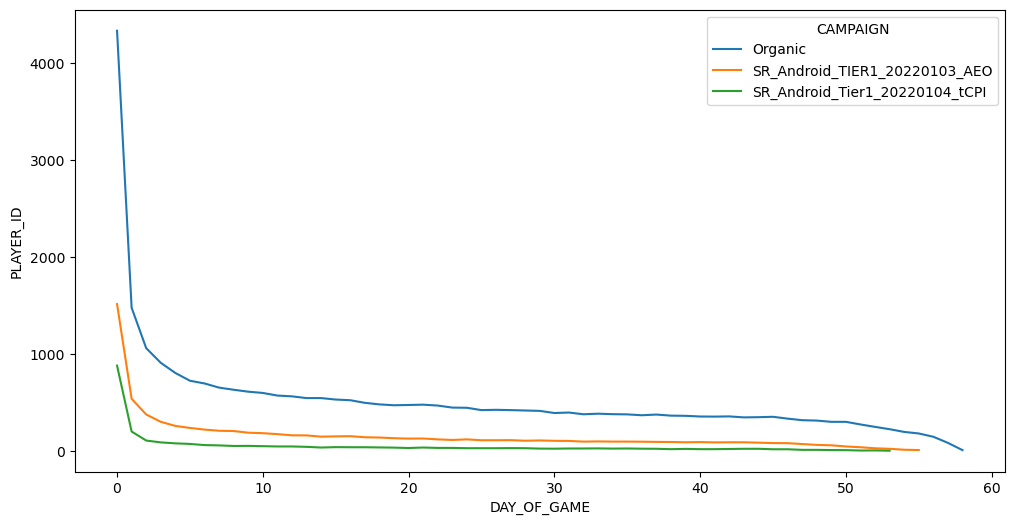

In [215]:
# Wykres
plt.figure(figsize=(12,6))
sns.lineplot(
            data=chart_data,
            x='DAY_OF_GAME',
            y='PLAYER_ID',
            hue='CAMPAIGN'
            );


In [252]:
# Przychody generowane przez graczy w każdej z kampanii

# Biorąc pod uwagę retencję i przychody najlepszymi kampaniamii wydają się być 'Organic' oraz 'SR_Android_US_20211209_AEO'

profit_no = pd.DataFrame(data_df.groupby('CAMPAIGN').sum()['PAID_IN_DAY'])
profit_no.reset_index(inplace=True)
profit_no = pd.merge(player_no,profit_no, how='left',on='CAMPAIGN')
profit_no['PLAYER_SPEND'] = profit_no.apply(lambda row: row['PAID_IN_DAY']/row['PLAYER_ID'], axis=1)
profit_no

,CAMPAIGN,PLAYER_ID,PAID_IN_DAY,PLAYER_SPEND
0,(WW) Slash & Roll Brand,10,0,0.000000
1,Organic,30553,23431,0.766897
2,SR_Android_DE_20211209_AEO,686,333,0.485423
3,SR_Android_PL_20210924_AAA,1,0,0.000000
4,SR_Android_TIER1_20220103_AEO,8753,5220,0.596367
5,SR_Android_Tier1_20220104_tCPI,2864,433,0.151187
6,SR_Android_US_20211209_AEO,2069,1719,0.830836
7,no_data,2348,1056,0.449744
8,restricted,1784,1291,0.723655
